# Pre-Process

In [ ]:
#@title AutoCrop Depedencies
!pip install --quiet autocrop
from PIL import Image
from autocrop import Cropper

In [ ]:
#@title Cloudinary Depedencies
import numpy as np 
import pandas as pd
import os
!pip install cloudinary --quiet
import cloudinary
from cloudinary import uploader, CloudinaryImage
import cloudinary.uploader
import cloudinary.api
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import shutil

In [ ]:
train = pd.read_csv('/kaggle/input/satriadata/data_process/dataset/train.csv')
dfs = pd.read_csv('/kaggle/input/satriadata/data_process/dataset/test.csv')

In [ ]:
files = [] # Nama file.

# Satu subfile ada 3 image.
for index, row in train.iterrows():
    files.append(str(row["nomor"]) + "_1.jpg") # Image 1.
    files.append(str(row["nomor"]) + "_2.jpg") # Image 2.
    files.append(str(row["nomor"]) + "_3.jpg") # Image 3.
    

dft = pd.DataFrame({
    "name": files,
})

## AutoCrop

In [ ]:
cropper = Cropper(face_percent=100)

In [ ]:
for filenames in list(dfs.id):
    cropped = cropper.crop(f'/kaggle/input/satriadata/dataset/dataset/test/{filenames}.jpg')
    try:
        image_cropped = Image.fromarray(cropped)
        image_cropped.save(f'{filenames}.jpg')
    except AttributeError:
        continue

for filenames in list(dft.id):
    cropped = cropper.crop(f'/kaggle/input/satriadata/dataset/dataset/train/{filenames}.jpg')
    try:
        image_cropped = Image.fromarray(cropped)
        image_cropped.save(f'{filenames}.jpg')
    except AttributeError:
        continue

## Cloudinary

In [ ]:
cloudinary.config(
    cloud_name='',
    api_key='',
    api_secret='',
    secure=True
)

In [ ]:
train_root = '/kaggle/input/satriadata/data_process/dataset/train'
test_root = '/kaggle/input/satriadata/data_process/dataset/test'

### Training Set

In [ ]:
train_dir = []
for file in list(dft['name']):
    train_dir.append(train_root + '/' + file)

train_dir[:5]

In [ ]:
x = 0
for file in train_dir:
    temp_img = cv2.imread(file, 1)
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    # plt.imshow(temp_img)
    
    pub_id = dft['id'][x]
    cloudinary.uploader.upload(file, public_id = pub_id)
    cropped_image = CloudinaryImage(pub_id).image(gravity='face', crop='crop')
    url_cropped_image = cropped_image.split('="')[1][:-3]
    r = requests.get(url_cropped_image, stream=True)
    
    filename = url_cropped_image.split("/")[-1]+".jpg"
    r.raw.decode_content = True
    with open(filename, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    
    cropped_img = cv2.imread(pub_id + ".jpg")
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    plt.imshow(cropped_img)

    x += 1

### Test Set

In [ ]:
test_dir = []
for file in list(dfs['id']):
    test_dir.append(test_root + '/' + file + '.jpg')

test_dir[:5]

In [ ]:
x = 0
for file in test_dir:
    temp_img = cv2.imread(file, 1)
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    # plt.imshow(temp_img)
    
    pub_id = dfs['id'][x]
    cloudinary.uploader.upload(file, public_id = pub_id)
    cropped_image = CloudinaryImage(pub_id).image(gravity='face', crop='crop')
    url_cropped_image = cropped_image.split('="')[1][:-3]
    r = requests.get(url_cropped_image, stream=True)
    
    filename = url_cropped_image.split("/")[-1]+".jpg"
    r.raw.decode_content = True
    with open(filename, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    
    cropped_img = cv2.imread(pub_id + ".jpg")
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    plt.imshow(cropped_img)

    x += 1

# Depedencies

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# !pip install --quiet torch
# !pip install --quiet timm

## Libraries

In [ ]:
# Set GPU Device.
from fastai.vision.all import *
torch.cuda.set_device(0)
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [ ]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.core import Datasets
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, GrandparentSplitter, RegexLabeller, ToTensor, IntToFloatTensor, Categorize, parent_label

from fastai.learner import Learner
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.metrics import error_rate, accuracy

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize, FlipItem
from fastai.vision.core import PILImage, imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner, create_head, create_body, num_features_model, default_split, has_pool_type, apply_init, _update_first_layer

import torch
from torch import nn

In [ ]:
# List of available EffNet Architectures.
# import timm
# from pprint import pprint
# model_names = timm.list_models('*efficientne*t*')
# pprint(model_names)

## Dataset

In [ ]:
train = pd.read_csv("../input/satriadata/data_process/dataset/train.csv")
train.head()

,nomor,jenis kelamin,usia
0,1,0,27
1,2,1,24
2,3,0,29
3,4,1,23
4,5,0,20


In [ ]:
files = [] # Nama file.
jk = [] # Jenis kelamin.
usia = [] # Usia.

# Satu subfile ada 3 image.
for index, row in train.iterrows():
    files.append(str(row["nomor"]) + "_1.jpg") # Image 1.
    jk.append(row["jenis kelamin"])
    usia.append(row["usia"])
    files.append(str(row["nomor"]) + "_2.jpg") # Image 2.
    jk.append(row["jenis kelamin"])
    usia.append(row["usia"])
    files.append(str(row["nomor"]) + "_3.jpg") # Image 3.
    jk.append(row["jenis kelamin"])
    usia.append(row["usia"])
    

df = pd.DataFrame({
    "name": files,
    "label": jk,
})
df2 = pd.DataFrame({
    "name": files,
    "label": usia,
})

In [ ]:
df.head()

,name,label
0,1_1.jpg,0
1,1_2.jpg,0
2,1_3.jpg,0
3,2_1.jpg,1
4,2_2.jpg,1


In [ ]:
nomor_lk = list(x[:-4] for x in df[df['label'] == 1]['name'])
nomor_pr = list(x[:-4] for x in df[df['label'] == 0]['name'])

In [ ]:
nomor_pr[:5]

['1_1', '1_2', '1_3', '3_1', '3_2']

In [ ]:
nomor_lk[:5]

['2_1', '2_2', '2_3', '4_1', '4_2']

# Input Data

In [ ]:
path = "../input/satriadata/train_processed"
filenames = get_image_files(path)
pat = r'/([^/]+)_\d+.*'

## Labelling Function

In [ ]:
def label_func(string):
    stringed = str(string)
    
    x = 1
    y = 0
    
    while True:
        if stringed[-x] != "/":
            x += 1
            y += 1
        else:
            break
            
    output = stringed[-y:][:-4]
    
    if output in nomor_pr:
        return 0
    else:
        return 1

## Data Block

In [ ]:
item = [
    ToTensor(), 
    Resize(500, ResizeMethod.Squish)
]

batch = [
    IntToFloatTensor(),
    Normalize.from_stats(*imagenet_stats)
]

In [ ]:
dfjk = ImageDataLoaders.from_df(df,
                                "../input/satriadata/",
                                folder='train_processed',
                                valid_pct=0.2,
                                item_tfms=item,
                                batch_tfms=batch,
                                bs=16, 
                                val_bs=8,
)

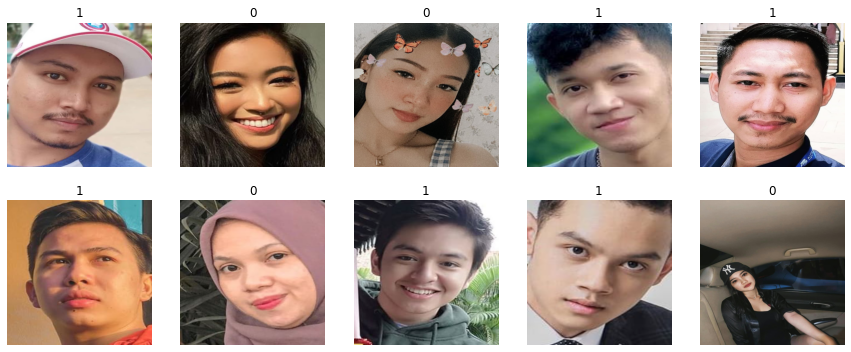

In [ ]:
dfjk.train.show_batch(max_n=10, nrows=2)

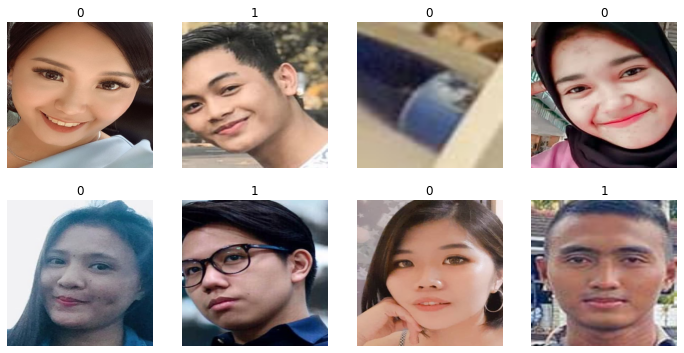

In [ ]:
dfjk.valid.show_batch(max_n=10, nrows=2)

In [ ]:
print("Label: " + str(dfjk.vocab))
print("Train size: " + str(len(dfjk.train_ds)))
print("Valid size: " + str(len(dfjk.valid_ds)))

Label: [0, 1]
Train size: 1848
Valid size: 462


# Model

In [ ]:
!pip install --quiet efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b3', num_classes=2)

In [ ]:
# def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    # "Creates a body from any model in the `timm` library."
    # model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    # _update_first_layer(model, n_in, pretrained)
    # if cut is None:
        # ll = list(enumerate(model.children()))
        # cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    # if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    # elif callable(cut): return cut(model)
    # else: raise NamedError("cut must be either integer or function")

In [ ]:
# body = create_timm_body('efficientnet_b4', pretrained=False)
# num_feat = num_features_model(nn.Sequential(*body.children()))
# head = create_head(num_feat, dfjk.c)
# model = nn.Sequential(body, head)
# apply_init(model[1], nn.init.kaiming_normal_)

In [ ]:
learn = Learner(dfjk, model,
                opt_func=Adam, 
                metrics=[accuracy, F1Score()], 
                loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.model_dir = '/kaggle/working/models'

In [ ]:
learn.unfreeze()
lr = learn.lr_find()

In [ ]:
mixup = MixUp(1.)

In [ ]:
learn.fit_one_cycle(100, 3e-3,
                    cbs=[SaveModelCallback(every_epoch=False, 
                                           with_opt=True,
                                           fname='best_effnet_model_base', 
                                           monitor='f1_score'),
                        mixup])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.697705,0.686256,0.567100,0.000000,01:33
1,0.687558,0.685999,0.567100,0.000000,01:26
2,0.661688,0.687332,0.569264,0.009950,01:25
3,0.601673,0.497759,0.835498,0.803109,01:26
4,0.581115,0.468218,0.848485,0.828431,01:25
5,0.577454,0.564058,0.768398,0.752887,01:25
6,0.567230,0.718383,0.727273,0.559441,01:25
7,0.560038,0.810925,0.681818,0.436782,01:25
8,0.562089,0.528965,0.831169,0.820276,01:25
9,0.543353,0.775350,0.785714,0.794179,01:25


Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 2 with f1_score value: 0.009950248756218907.
Better model found at epoch 3 with f1_score value: 0.8031088082901554.
Better model found at epoch 4 with f1_score value: 0.8284313725490196.
Better model found at epoch 15 with f1_score value: 0.8877551020408163.
Better model found at epoch 24 with f1_score value: 0.895.
Better model found at epoch 28 with f1_score value: 0.9095477386934674.
Better model found at epoch 37 with f1_score value: 0.91.
Better model found at epoch 39 with f1_score value: 0.9145728643216081.
Better model found at epoch 48 with f1_score value: 0.922279792746114.
Better model found at epoch 51 with f1_score value: 0.9257425742574258.
Better model found at epoch 52 with f1_score value: 0.9280397022332506.
Better model found at epoch 56 with f1_score value: 0.9316455696202531.
Better model found at epoch 65 with f1_score value: 0.9319899244332494.


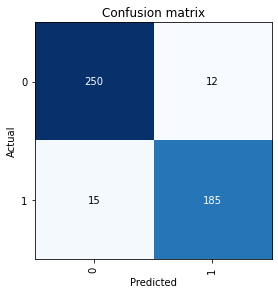

In [ ]:
conf_mat = ClassificationInterpretation.from_learner(learn)
conf_mat.plot_confusion_matrix()

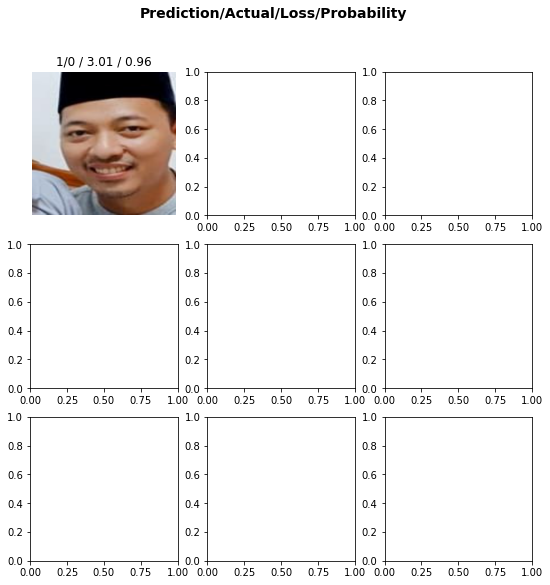

In [ ]:
conf_mat.plot_top_losses(9, nrows=3)

In [ ]:
learn.save('final_model')

Path('/kaggle/working/models/final_model.pth')

# Prediction

In [ ]:
test = pd.read_csv('/kaggle/input/satriadata/data_process/dataset/test.csv')

In [ ]:
dirname = '/kaggle/input/satriadata/test_processed'

In [ ]:
x = 0
for file in list(test['id']):
    print(dirname + '/' + file + '.jpg')
    x += 1
    if x == 5:
        break

In [ ]:
prediction = []
for file in list(test['id']):
    pred = learn.predict(dirname + '/' + file + '.jpg')[0]
    prediction.append(pred)

In [ ]:
test['pred'] = prediction
test.to_csv('submission.csv')